In [111]:
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn import decomposition
import matplotlib
plt.style.use('seaborn-talk')
matplotlib.rcParams.update({'font.size': 15})
# from sklearn.datasets import fetch_mldata

## Toy gaussian data in 2D and basic functions

In [2]:
def gaussian_data(mus, covmats, n):
    g1 = np.random.multivariate_normal(mus[0], covmats[0], int(n / 2))
    y1 = np.ones((int(n / 2), 1))
    xy1 = np.concatenate((g1, y1), axis=1)
    g2 = np.random.multivariate_normal(mus[1], covmats[1], int((n + 1) / 2))
    y2 = - np.ones((int((n + 1) / 2), 1))
    xy2 = np.concatenate((g2, y2), axis=1)
    xy = np.concatenate((xy1, xy2), axis=0)
    np.random.shuffle(xy)
    return xy                      

In [3]:
def center_and_reduce(xmat, inplace=True):
    d = xmat.shape[0]
    n = xmat.shape[1]
    xmean = np.mean(xmat, axis=1)
    xvar = np.var(xmat, axis=1)
    meanmat = np.repeat(xmean.reshape((d,1)), n, axis=1)
    varmat = np.repeat(xvar.reshape((d,1)), n, axis=1)
    if inplace :
        xmat = (1 / varmat) * (xmat - meanmat)
    else:
        return (1 / varmat) * (xmat - meanmat)

In [4]:
def data_from_label(xmat, y, label):
    indices = np.argwhere(y == label)
    return xmat[:, indices[:, 0]]

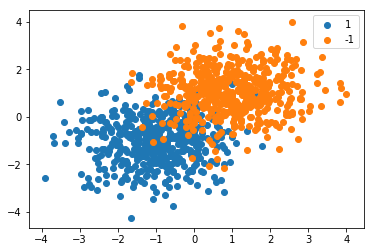

In [5]:
# Parameters for gaussian data
mus = ([-1, -1], [1, 1])
covs = (np.eye(2), np.eye(2))

# Create data
xy = gaussian_data(mus, covs, 1000)

# Separate data and labels
xmat = xy[:, :2].T
y= xy[:,2].T

# Center and reduce
center_and_reduce(xmat)

# Plot
xs_plus1 = data_from_label(xmat, y, 1)
xs_minus1 = data_from_label(xmat, y, -1)
plt.scatter(xs_plus1[0, :], xs_plus1[1, :], label="1")
plt.scatter(xs_minus1[0, :], xs_minus1[1, :], label="-1")
plt.legend()
plt.show()

## Class wrapper for loss functions
We create here an almost empty class model for losses functions. The objective is to be able to change loss function easily

In [6]:
class LossFunc:
    
    def __init__(self):
        self.primal = None
        self.dual = None
        self.sdca_update = None
        self.sgd_update = None
        self.pegasos_batch_update = None
    
    def set_primal(self, func):
        self.primal = func
    
    def set_dual(self, func):
        self.dual = func
    
    def set_sdca_update(self, func):
        self.sdca_update = func
    
    def set_sgd_update(self, func):
        self.sgd_update = func
    
    def set_pegasos_batch_update(self, func):
        self.pegasos_batch_update = func

## Definition of Hinge loss using the LossFunc class wrapper
We define the hinge loss using the class framework defined above

In [7]:
def vector_hinge_loss(a, y):
    return np.maximum(0, 1 - y * a)

def vector_hinge_dual(alpha, y):
    prod = alpha * y
    prod[prod > 0] = np.inf
    prod[prod < -1] = np.inf
    return prod

def hinge_delta_alpha(w, xi, yi, alphai, lamb):
    n = xi.shape[0]
    q = lamb * n * (1 - np.dot(xi.T, w) * yi) / np.power(np.linalg.norm(xi), 2)
    q += alphai * yi
    return yi * max(0, min(1, q)) - alphai
    
hinge = LossFunc()
hinge.set_primal(vector_hinge_loss)
hinge.set_dual(vector_hinge_dual)
hinge.set_sdca_update(hinge_delta_alpha)

## Primal and dual of cumulative regularized loss
We define in this section:
1. Some intermediaries functions
1. The primal dual correspondance function (associating w(alpha) to alpha)
1. The primal and dual cumulative loss functions
1. The duality gap function

In [8]:
def xmatT_dot_w(xmat, w):
    return np.dot(xmat.T, w)

In [9]:
def cum_loss(w, xmat, y, lamb, lossfunc=hinge):
    a = xmatT_dot_w(xmat, w)
    cumloss = np.mean(lossfunc.primal(a, y))
    reg = (lamb / 2) * np.power(np.linalg.norm(w), 2)
    return cumloss + reg

In [10]:
def alpha_to_w(alpha, xmat, lamb):
    n = xmat.shape[1]
    return (1 / (n * lamb)) * np.dot(xmat, alpha)

In [11]:
def cum_loss_dual(alpha, xmat, y, lamb, lossfunc=hinge):
    cumlossdual = np.mean(- lossfunc.dual(- alpha, y))
    w = alpha_to_w(alpha, xmat, lamb)
    reg = (lamb / 2) * np.power(np.linalg.norm(w), 2)
    return cumlossdual - reg

In [12]:
# Test for those few first functions
w_test = np.array([1, 1])
w_test = w_test.reshape((2, 1))
a = xmatT_dot_w(w_test, xmat)
h = vector_hinge_loss(a, y)
cumloss = cum_loss(w_test, xmat, y, 1)
n = xmat.shape[1]
alpha_test = 0.5 * np.ones((n,))
cum_loss_dual(alpha_test, xmat, y, 1)

-inf

In [13]:
def duality_gap(alpha, xmat, y, lamb, lossfunc=hinge):
    w = alpha_to_w(alpha, xmat, lamb)
    p = cum_loss(w, xmat, y, lamb, lossfunc)
    d = cum_loss_dual(alpha, xmat, y, lamb, lossfunc)
    return p - d

## Modified SGD for initialization

We wish to find $\alpha_t$ that maximizes : 
$$ - \phi_t^{\star}(-\alpha_t) - \frac{\lambda t}{2} ||w^{(t-1)} + (\lambda t)^{-1} \alpha_t x_t ||^2$$

Developping the previous expression yields : 
$$ \alpha_t y_t - \frac{\lambda t}{2} ( ||w^{(t-1)}||^2 + 2 \frac{\alpha_t}{\lambda t} \langle w^{(t-1)}, x_t \rangle + \frac{\alpha_t^2}{\lambda^2 t^2}||x_t||^2 )$$

This is a second order polynomial in $\alpha_t$. With a negative coefficient on the second order term. Thus this is concave. Setting the derivative w.r.t $\alpha_t$ yields : 

$$ y_t - \langle w^{(t-1)}, x_t \rangle - \frac{\alpha_t^2}{2 \lambda t} = 0$$


This gives us an optimal $\alpha_t$ which is given by : 
$$ \alpha_t= \frac{\lambda t}{||x_t||^2} (y_t - x_t^T w^{(t-1)})$$

In [14]:
def hinge_sgd_update(w, xt, yt, lamb, t):
    wdotx = np.dot(xt.T, w)
    xsqrnorm = np.power(np.linalg.norm(xt), 2)
    return ((lamb * t) / xsqrnorm) * (yt - wdotx)

hinge.set_sgd_update(hinge_sgd_update)

In [15]:
def modified_sgd(xmat, y, lamb, lossfunc=hinge):
    d = xmat.shape[0]
    n = xmat.shape[1]
    alpha = np.zeros((n, ))
    w = np.zeros((d, ))
    for t in range(0, n):
        alpha[t] = lossfunc.sgd_update(w, xmat[:, t], y[t], lamb, t)
        w = alpha_to_w(alpha[:t + 1], xmat[:, :t + 1], lamb)
    return alpha, w       

## Deduction of a classifier

In [16]:
def classify(wstar, xmat_test):
    prod = np.dot(xmat_test.T, wstar)
    prod[prod >= 0] = 1
    prod[prod < 0] = -1
    return prod

In [17]:
def get_score(w, xtest, ytest):
    ypred = classify(w, xtest)
    score = metrics.zero_one_loss(ypred, ytest)
    return score

## SDCA Perm

In [27]:
def sdca_perm_epoch(w, alpha, xmat, y, lamb, lossfunc=hinge):
    n = xmat.shape[1]
    inds = np.array(range(0, n))
    np.random.shuffle(inds)
    for j in range(0, n):
        i = inds[j]
        delta = lossfunc.sdca_update(w, xmat[:, i], y[i], alpha[i], lamb)
        alpha[i] += delta
        w += (1 / (lamb * n)) * delta * xmat[:, i]

In [37]:
def sdca_perm(alpha0, xmat, y, lamb, nepochs, epsilon, lossfunc=hinge, sgd_first=True, xtest=None, ytest=None):
    n = xmat.shape[1]
    alpha = alpha0.copy()
    loss_track = []
    w = alpha_to_w(alpha0, xmat, lamb)
    loss_track.append(cum_loss(w, xmat, y, lamb, lossfunc))
    # Keep track of the duality gaps
    gaps_track = []
    gap = duality_gap(alpha, xmat, y, lamb, lossfunc)
    gaps_track.append(gap)
    # Keep track of the score on the test database
    if isinstance(xtest, np.ndarray):
        score_test = []
        score = get_score(w, xtest, ytest)
        score_test.append(score)
    k = 0
    perfs = [0]
    if sgd_first :
        start = time.clock()
        alpha0, w = modified_sgd(xmat, y, 1)
        end = time.clock()
        perfs.append(end - start)
        k += 1
        loss_track.append(cum_loss(w, xmat, y, lamb, lossfunc))
    while (gap > epsilon) and (k < nepochs) :
    #while k < nepochs :
        start = time.clock()
        sdca_perm_epoch(w, alpha, xmat, y, lamb, lossfunc)
        end = time.clock()
        perfs.append(end - start)
        k += 1
        loss_track.append(cum_loss(w, xmat, y, lamb, lossfunc))
        gap = duality_gap(alpha, xmat, y, lamb, lossfunc)
        gaps_track.append(gap)
        if isinstance(xtest, np.ndarray):
            score = get_score(w, xtest, ytest)
            score_test.append(score)
    if isinstance(xtest, np.ndarray):
        return w, alpha, loss_track, perfs, gaps_track, score_test
    else:
        return w, alpha, loss_track, perfs, gaps_track

## Pegasos algorithm (=stochastic subgradient descent)

In [29]:
def hinge_loss_update(w, xmat, y, eta, lamb, batch_indexes):
    k = batch_indexes.shape[0]
    restricted_xmat = xmat[:, batch_indexes]
    restricted_y = y[batch_indexes]
    dot = xmatT_dot_w(restricted_xmat, w)
    indic = (restricted_y * dot < 1).astype(np.int64)
    summed_vec = np.dot(restricted_xmat, restricted_y * indic)
    w *= (1 - eta * lamb)
    w += (eta / k) * summed_vec

hinge.set_pegasos_batch_update(hinge_loss_update)

In [30]:
def pegasos_algorithm(w, xmat, y, lamb, k, nepochs, lossfunc=hinge, xtest=None, ytest=None):
    n = xmat.shape[1]
    loss_track = []
    loss_track.append(cum_loss(w, xmat, y, lamb, lossfunc))
    t = 1
    perfs = [0]
    if isinstance(xtest, np.ndarray):
        score_test = []
        score = get_score(w, xtest, ytest)
        score_test.append(score)
    for epoch in range(0, nepochs) : 
        start = time.clock()
        indexes = np.array(range(0, n))
        np.random.shuffle(indexes)
        for i in range(0, n // k):
            eta = 1 / (lamb * t)
            lossfunc.pegasos_batch_update(w, xmat, y, eta, lamb, indexes[i * k : (i + 1) * k])
            # loss_track.append(cum_loss(w, xmat, y, lamb, lossfunc))
            t += 1
        end = time.clock()
        perfs.append(end - start)
        loss_track.append(cum_loss(w, xmat, y, lamb, lossfunc))
        if isinstance(xtest, np.ndarray):
            score = get_score(w, xtest, ytest)
            score_test.append(score)
    if isinstance(xtest, np.ndarray):
        return loss_track, perfs, score_test  
    else : 
        return loss_track, perfs

## Deduction of a classifier and adaptation to multiclass problems

In [31]:
def classify(wstar, xmat_test):
    prod = np.dot(xmat_test.T, wstar)
    prod[prod >= 0] = 1
    prod[prod < 0] = -1
    return prod

In [32]:
def one_one_splitting(xmat, y):
    classes = np.unique(y)
    nclasses = classes.shape[0]
    problems = {}
    indexes = []
    for i in range(0, nclasses):
        indexes.append(np.argwhere(y == classes[i])[:, 0])
    for i in range(0, nclasses):
        for j in range(i + 1, nclasses):
            subindexes = np.concatenate((indexes[i], indexes[j]))
            problems[(i, j)] = (xmat[:, subindexes], y[subindexes])
    return problems

In [33]:
def multiclass_pegasos_svm(problems, ws, lamb, k, nepochs):
    for key in problems.keys():
        
    
    

IndentationError: expected an indented block (<ipython-input-33-1521df1e7d28>, line 5)

In [34]:
def pegasos_multiclass_svm(ws, xmat, y, lamb, batchsize, nepochs, hinge):
    classes = np.unique(y)
    nclasses = classes.shape[0]
    problems = []
    for i in range(0, nclasses):
        for j in range(i + 1, nclasses):
            
            problems.append(())

## Hyperplane plotting function

In [35]:
def hyperplane(w, xgrid):
    return (-w[0] / w[1]) * xgrid

## Test on toy gaussian 2D data

### SDCA vs Pegasos

In [38]:
lamb = 0.1
d = xmat.shape[0]
n = xmat.shape[1]
alpha0 = np.zeros((n, ))
w_pegasos = np.zeros((d, ))

# First epoch using SGD
# alpha0, w0 = modified_sgd(xmat, y, 1)

# SDCA epochs
w_sdca, alpha_sdca, losses_sdca, perfs_sdca, gaps_sdca = sdca_perm(alpha0, xmat, y, lamb, 20, 0.001)

# Pegasos
losses_pegasos, perfs_pegasos = pegasos_algorithm(w_pegasos, xmat, y, lamb, 1, 50, lossfunc=hinge)

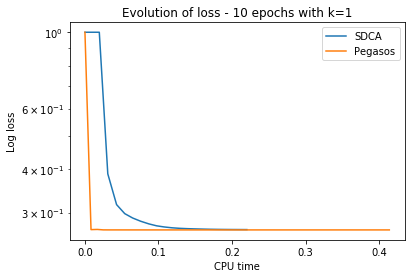

In [39]:
plt.semilogy(np.cumsum(perfs_sdca), losses_sdca, label="SDCA")
plt.semilogy(np.cumsum(perfs_pegasos), losses_pegasos, label="Pegasos")
plt.ylabel("Log loss")
plt.xlabel("CPU time")
plt.legend()
plt.title("Evolution of loss - 10 epochs with k=1")
plt.show()

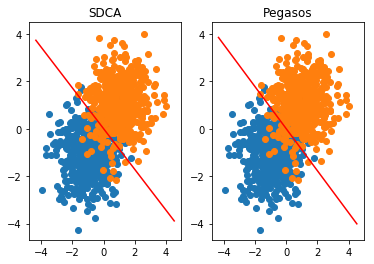

In [40]:
fig, axes = plt.subplots(1, 2)
xs_plus1 = data_from_label(xmat, y, 1)
xs_minus1 = data_from_label(xmat, y, -1)
axes[0].scatter(xs_plus1[0, :], xs_plus1[1, :], label="1")
axes[0].scatter(xs_minus1[0, :], xs_minus1[1, :], label="-1")
axes[1].scatter(xs_plus1[0, :], xs_plus1[1, :], label="1")
axes[1].scatter(xs_minus1[0, :], xs_minus1[1, :], label="-1")
xlim0 = axes[0].get_xlim()
xlim1 = axes[1].get_xlim()
xgrid0 = np.linspace(xlim0[0], xlim0[1], 1000)
xgrid1 = np.linspace(xlim1[0], xlim1[1], 1000)
sep0 = (xgrid0, hyperplane(w_sdca, xgrid0))
sep1 = (xgrid1, hyperplane(w_pegasos, xgrid1))
axes[0].plot(sep0[0], sep0[1], c="r")
axes[1].plot(sep1[0], sep1[1], c="r")
axes[0].set_title("SDCA")
axes[1].set_title("Pegasos")
plt.show()

## Test on blood cells automatic classification

In [74]:
# Load database 
path = os.getcwd() + "/Cropped/"
neutrophils_train = np.loadtxt(path + "neutrophils_train.gz")
lymphocytes_train = np.loadtxt(path + "lymphocytes_train.gz")
neutrophils_test = np.loadtxt(path + "neutrophils_test.gz")
lymphocytes_test = np.loadtxt(path + "lymphocytes_test.gz")

In [75]:
def add_labels(data, label):
    n = data.shape[1]
    y = label * np.ones((1, n))
    data = np.concatenate((data, y))
    return data

In [76]:
# Add labels
neutrophils_train = add_labels(neutrophils_train, 1)
neutrophils_test = add_labels(neutrophils_test, 1)
lymphocytes_train = add_labels(lymphocytes_train, -1)
lymphocytes_test = add_labels(lymphocytes_test, -1)

In [77]:
# Concatenate
data_train =  np.concatenate((neutrophils_train, lymphocytes_train), axis=1)
data_test =  np.concatenate((neutrophils_test, lymphocytes_test), axis=1)
# Shuffle the data
data_train = (np.random.permutation(data_train.T)).T
data_test = (np.random.permutation(data_test.T)).T

In [78]:
# Separate data from labels once shuffled
xtrain = data_train[0:data_train.shape[0] - 1, :]
ytrain = data_train[-1, :]
xtest = data_test[0:data_test.shape[0] - 1, :]
ytest = data_test[-1, :]

In [91]:
lamb = 0.2
d = xtrain.shape[0]
n = xtrain.shape[1]
alpha0 = np.zeros((n, ))
w_pegasos = np.zeros((d, ))
nepochs_sdca = 200
nepochs_pegasos = 100
minibatch_pegasos = 100

# SDCA epochs
w_sdca, alpha_sdca, losses_sdca, perfs_sdca, gaps_sdca, scores_sdca = sdca_perm(alpha0, 
                                                                           xtrain, 
                                                                           ytrain, 
                                                                           lamb, 
                                                                           nepochs_sdca, 
                                                                           0.000001, 
                                                                           sgd_first=False, 
                                                                          xtest=xtest, 
                                                                          ytest=ytest)
print(np.sum(perfs_sdca))

# Pegasos
losses_pegasos, perfs_pegasos, scores_pegasos= pegasos_algorithm(w_pegasos, xtrain, ytrain, 
                                                  lamb, minibatch_pegasos, nepochs_pegasos, 
                                                  xtest=xtest, ytest=ytest)
print(np.sum(perfs_pegasos))

517.332799
729.177418


In [97]:
# SDCA epochs
nepochs_sdca = 300
w_sdca, alpha_sdca, losses_sdca, perfs_sdca, gaps_sdca, scores_sdca = sdca_perm(alpha0, 
                                                                           xtrain, 
                                                                           ytrain, 
                                                                           lamb, 
                                                                           nepochs_sdca, 
                                                                           0.000001, 
                                                                           sgd_first=False, 
                                                                          xtest=xtest, 
                                                                          ytest=ytest)

In [113]:
output_path = os.getcwd() + "/Graphs/"

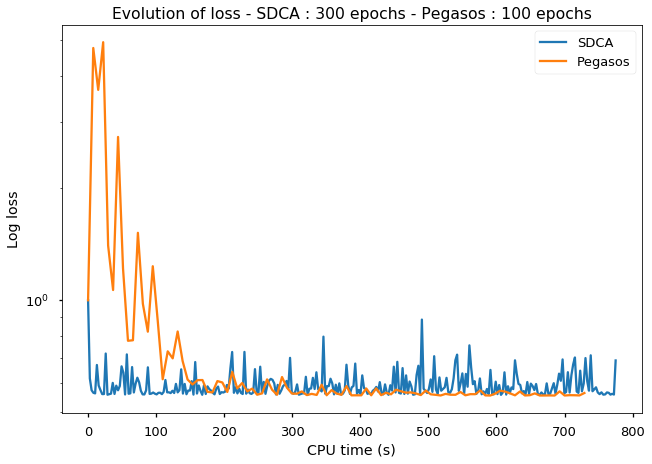

In [119]:
plt.semilogy(np.cumsum(perfs_sdca), losses_sdca, label="SDCA")
plt.semilogy(np.cumsum(perfs_pegasos), losses_pegasos, label="Pegasos")
plt.ylabel("Log loss")
plt.xlabel("CPU time (s)")
plt.legend()
plt.title("Evolution of loss - SDCA : 300 epochs - Pegasos : 100 epochs")
plt.savefig(output_path + "Noisy_Logloss.svg")
plt.show()

In [99]:
ypred = classify(w_sdca, xtest)
print(metrics.zero_one_loss(ypred, ytest))

0.245176848875


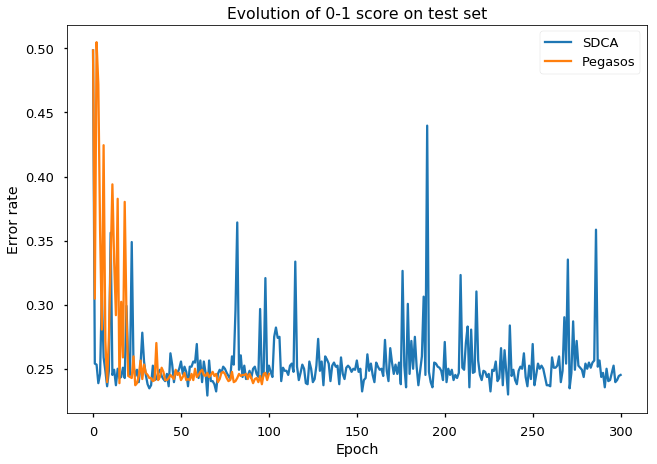

In [118]:
plt.plot(scores_sdca, label="SDCA")
plt.plot(scores_pegasos, label="Pegasos")
plt.title("Evolution of 0-1 score on test set")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Error rate")
plt.savefig(output_path + "Noisy_Test_Score.svg")

## Test on clothes item classification on the Fashion MNIST database

In [31]:
# Load fashion MNIST from computer
path = "C://Users//Dimitri//Desktop//ENSAE3A//SOADML//FashionMNIST//"
train_pd = pd.read_csv(path + "fashion-mnist_train.csv")
test_pd = pd.read_csv(path + "fashion-mnist_test.csv")

In [32]:
# Selection on 0 (t shirts) and 1 (trousers) labels
train_pd = train_pd[train_pd.label <= 1]
train_pd["label"] = train_pd["label"].replace(0, -1)
test_pd = test_pd[test_pd.label <= 1]
test_pd["label"] = test_pd["label"].replace(0, -1)

In [33]:
# Store data in numpy matrixes
train_np = train_pd.as_matrix()
ytrain = train_np[:, 0]
xtrain = train_np[:, 1:].T
test_np = test_pd.as_matrix()
ytest = test_np[:, 0]
xtest = test_np[:, 1:].T

In [34]:
# Center and reduce the data
center_and_reduce(xtrain)

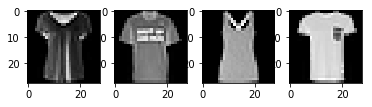

In [35]:
# Draw of few example of tshirts
example_tshirt1 = xtrain[:, 7].reshape((28, 28))
example_tshirt2 = xtrain[:, 8].reshape((28, 28))
example_tshirt3 = xtrain[:, 3].reshape((28, 28))
example_tshirt4 = xtrain[:, 17].reshape((28, 28))
fig, axes = plt.subplots(1, 4)
axes[0].imshow(example_tshirt1, cmap="gray")
axes[1].imshow(example_tshirt2, cmap="gray")
axes[2].imshow(example_tshirt3, cmap="gray")
axes[3].imshow(example_tshirt4, cmap="gray")
plt.show()

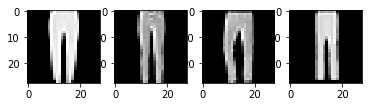

In [36]:
# Draw a few examples of trousers
example_trousers1 = xtrain[:, 4].reshape((28, 28))
example_trousers2 = xtrain[:, 9].reshape((28, 28))
example_trousers3 = xtrain[:, 11].reshape((28, 28))
example_trousers4 = xtrain[:, 22].reshape((28, 28))
fig, axes = plt.subplots(1, 4)
axes[0].imshow(example_trousers1, cmap="gray")
axes[1].imshow(example_trousers2, cmap="gray")
axes[2].imshow(example_trousers3, cmap="gray")
axes[3].imshow(example_trousers4, cmap="gray")
plt.show()

## PCA for dimension reduction

In [37]:
def compute_pca(xmat, ncomps):
    pca = decomposition.RandomizedPCA(n_components=ncomps, whiten=True).fit(xmat.T)
    return pca

In [38]:
def pca_dimension_reduction(pca, xmat):
    return pca.transform(xmat.T).T

In [39]:
# Reduce dimension
ncomps = 10
pca_xtrain = compute_pca(xtrain, ncomps)
xtrain_reduced = pca_dimension_reduction(pca_xtrain, xtrain)
xtest_reduced = pca_dimension_reduction(pca_xtrain, xtest)
components = pca_xtrain.components_.T
projected = np.dot(components, xtrain_reduced)

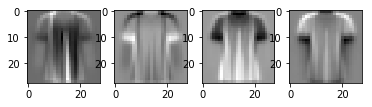

In [40]:
# Draw of few example of tshirts in reduced dimention
example_tshirt1 = projected[:, 7].reshape((28, 28))
example_tshirt2 = projected[:, 8].reshape((28, 28))
example_tshirt3 = projected[:, 3].reshape((28, 28))
example_tshirt4 = projected[:, 17].reshape((28, 28))
fig, axes = plt.subplots(1, 4)
axes[0].imshow(example_tshirt1, cmap="gray")
axes[1].imshow(example_tshirt2, cmap="gray")
axes[2].imshow(example_tshirt3, cmap="gray")
axes[3].imshow(example_tshirt4, cmap="gray")
plt.show()

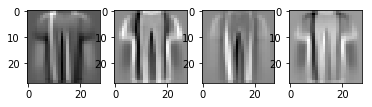

In [41]:
# Draw a few examples of trousers in reduced dimension
example_trousers1 = projected[:, 4].reshape((28, 28))
example_trousers2 = projected[:, 9].reshape((28, 28))
example_trousers3 = projected[:, 11].reshape((28, 28))
example_trousers4 = projected[:, 22].reshape((28, 28))
fig, axes = plt.subplots(1, 4)
axes[0].imshow(example_trousers1, cmap="gray")
axes[1].imshow(example_trousers2, cmap="gray")
axes[2].imshow(example_trousers3, cmap="gray")
axes[3].imshow(example_trousers4, cmap="gray")
plt.show()

## Comparison on original data

In [77]:
lamb = 0.1
alpha0 = np.zeros((n, ))
w_pegasos = np.zeros((d, ))
nepochs_sdca = 30
nepochs_pegasos = 100
minibatch_pegasos = 100

# SDCA epochs
w_sdca, alpha_sdca, losses_sdca, perfs_sdca, gaps_sdca, scores_sdca = sdca_perm(alpha0, 
                                                                           xtrain, 
                                                                           ytrain, 
                                                                           lamb, 
                                                                           nepochs_sdca, 
                                                                           0.001, 
                                                                           sgd_first=False, 
                                                                           xtest=xtest, 
                                                                           ytest=ytest)
print(np.sum(perfs_sdca))

# Pegasos
losses_pegasos, perfs_pegasos = pegasos_algorithm(w_pegasos, xtrain, ytrain, lamb, minibatch_pegasos, nepochs_pegasos)
print(np.sum(perfs_pegasos))

18.968215391
14.4370699126


In [80]:
plt.plot(scores_sdca)
plt.title("Evolution of 0-1 score on test set")
plt.xlabel("Epoch")
plt.ylabel("0-1 score")
plt.show()

NameError: name 'scores_sdca' is not defined

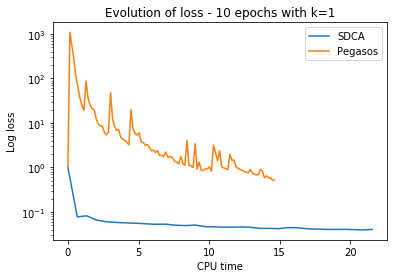

In [57]:
plt.semilogy(np.cumsum(perfs_sdca), losses_sdca, label="SDCA")
plt.semilogy(np.cumsum(perfs_pegasos), losses_pegasos, label="Pegasos")
plt.ylabel("Log loss")
plt.xlabel("CPU time")
plt.legend()
plt.title("Evolution of loss - 10 epochs with k=1")
plt.show()

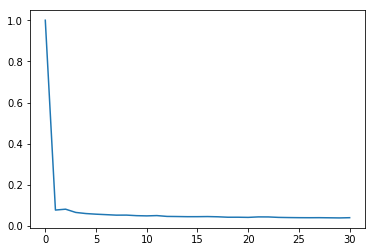

[1.0, 0.077614822458359337, 0.081864408772328243, 0.066095728347284693, 0.060647924104458184, 0.0575850580685369, 0.055264872731112281, 0.052874158498210519, 0.053091091100334206, 0.050396293922998561, 0.049308843516575995, 0.050744716514841255, 0.046714105337330246, 0.046167194774926729, 0.045413685343953354, 0.045469828503061492, 0.045997535726536039, 0.044898394942814959, 0.042735358968459078, 0.042812215253471252, 0.042019628577159254, 0.044356324319962566, 0.04416129049118573, 0.041944936510838624, 0.041139741272936028, 0.04059567351500485, 0.040374066401065202, 0.040597032684951746, 0.040024129548877595, 0.039427639128120855, 0.040516500578619698]


In [62]:
# Plot duality gap
plt.plot(gaps_sdca)
plt.show()
print(gaps_sdca)

## Comparison on PCA reduced data

In [42]:
lamb = 0.1
d = xtrain_reduced.shape[0]
n = xtrain_reduced.shape[1]
alpha0 = np.zeros((n, ))
w_pegasos = np.zeros((d, ))

# SDCA epochs
sdca_begin = time.perf_counter()
w_sdca, alpha_sdca, losses_sdca, perfs_sdca = sdca_perm(alpha0, xtrain_reduced, ytrain, lamb, 20, 0.001)
sdca_time = time.perf_counter() - sdca_begin
print(sdca_time)

# Pegasos
pegasos_begin = time.perf_counter()
losses_pegasos, perfs_pegasos = pegasos_algorithm(w_pegasos, xtrain_reduced, ytrain, lamb, 1, 20)
pegasos_time = time.perf_counter() - pegasos_begin
print(pegasos_time)

6.009210407585215
4.458541191523977


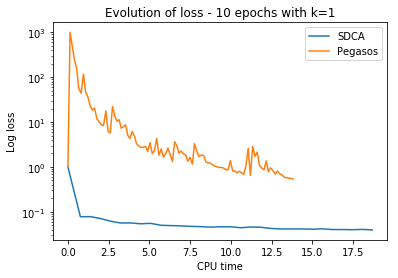

In [48]:
plt.semilogy(np.cumsum(perfs_sdca), losses_sdca, label="SDCA")
plt.semilogy(np.cumsum(perfs_pegasos), losses_pegasos, label="Pegasos")
plt.ylabel("Log loss")
plt.xlabel("CPU time")
plt.legend()
plt.title("Evolution of loss - 10 epochs with k=1")
plt.show()

In [176]:
lamb = 0.1
d = xtrain.shape[0]
n = xtrain.shape[1]
alpha0 = np.zeros((n, ))
w_pegasos = np.zeros((d, ))

# SDCA epochs
sdca_begin = time.perf_counter()
w_sdca, alpha_sdca, losses_sdca = sdca_perm(alpha0, xtrain, ytrain, lamb, 20, 0.001)
sdca_time = time.perf_counter() - sdca_begin
print(sdca_time)

# Pegasos
pegasos_begin = time.perf_counter()
losses_pegasos = pegasos_algorithm(w_pegasos, xtrain, ytrain, lamb, 1, 20)
pegasos_time = time.perf_counter() - pegasos_begin
print(pegasos_time)

302.33478507979453
15.066523886889627


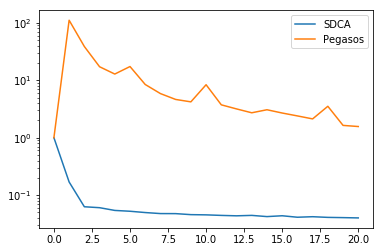

In [177]:
plt.semilogy(losses_sdca, label="SDCA")
plt.semilogy(losses_pegasos, label="Pegasos")
plt.legend()
plt.show()

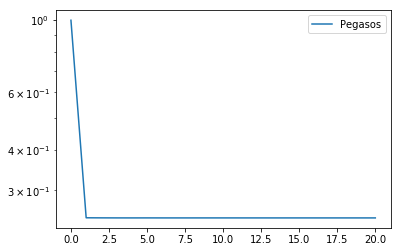

In [92]:
plt.semilogy(losses_pegasos, label="Pegasos")
plt.legend()
plt.show()

In [95]:
# Pegasos
lamb = 0.1
d = xtrain_reduced.shape[0]
n = xtrain_reduced.shape[1]
alpha0 = np.zeros((n, ))
w_pegasos = np.zeros((d, ))
pegasos_begin = time.perf_counter()
losses_pegasos = pegasos_algorithm(w_pegasos, xtrain_reduced, ytrain, lamb, 100, 1000, lossfunc=hinge)
pegasos_time = time.perf_counter() - pegasos_begin
print(pegasos_time)

4.965646466949693


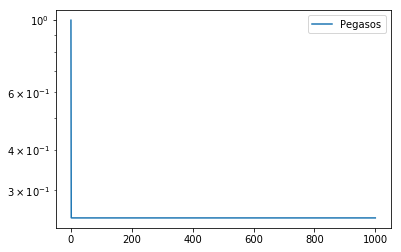

In [96]:
# plt.semilogy(losses_sdca, label="SDCA")
plt.semilogy(losses_pegasos, label="Pegasos")
plt.legend()
plt.show()

In [561]:
n = xtrain.shape[1]
d = xtrain.shape[0]
alpha0 = np.zeros((n, ))
wrandom = np.random.normal(0, 1, d)

In [542]:
# SDCA epochs
wstar, alphastar, losses, gaps = sdca_perm(alpha0, xtrain, ytrain, 0.01, 50, 0.0001)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


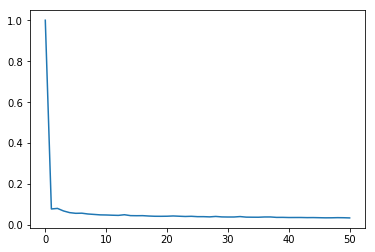

In [543]:
plt.plot(losses)
plt.show()

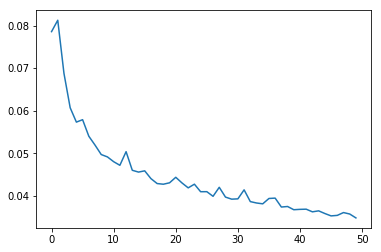

In [544]:
plt.plot(gaps)
plt.show()

In [97]:
ypred = classify(w_pegasos, xtest_reduced)

In [37]:
ytest

array([-1,  1, -1, ..., -1, -1,  1], dtype=int64)

In [98]:
print(metrics.zero_one_loss(ypred, ytest))

0.038
